## CH5S3: Multivariate Copulas for Claim Types

This script will be divided in the following parts:
    
1. Fitting multivariate copulas for raw claim types
2. Simulations to obtain VaR and TVaR with parametric copulas
3. Comparison between Empirical marginals vs. Parametric marginals


In [3]:
#loading the required libraries:
import numpy as np
import itertools
import random
from statistics import mean 
import tqdm
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copulae
import scipy.stats as ss


#changing the plot configuration:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('seaborn')

### 1. Fitting multivariate copulas for raw claim types

In [4]:
#loading the raw claims dataset:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Raw by Type/aggregated_series.csv")

#adding the marginals to the claim types:
df['Fpdx'] = ss.nbinom.cdf(df['pdx'], 2.139883173181995, 0.00922814420430195)
df['Fplx'] = ss.nbinom.cdf(df['plx'], 1.7579089737306162, 0.006834721956499432)
df['Fpds'] = ss.loglaplace.cdf(df['pds'], 2.481704232311386, 0, 37891.93289315458)
df['Fpls'] = ss.lognorm.cdf(df['pls'],  0.9086819314521254, 0.0, 31402.11730335455)
df.head()

,Date,pdx,pds,plx,pls,cbx,cbs,cpx,cps,Fpdx,Fplx,Fpds,Fpls
0,2003-01-01,258,47806.22,162,48506.85,160,25260.04,287,83758.85,0.656474,0.384473,0.719151,0.683863
1,2003-02-01,349,55287.03,204,48309.05,376,56751.91,200,52267.65,0.810250,0.489878,0.804214,0.682261
2,2003-03-01,375,62232.51,334,81314.60,495,82218.08,224,60334.01,0.841280,0.732862,0.854039,0.852466
3,2003-04-01,402,71880.07,413,90177.39,688,112881.10,154,52320.24,0.868594,0.825312,0.897929,0.877162
4,2003-05-01,372,61494.99,325,68181.76,592,99571.28,154,41398.91,0.837948,0.719966,0.849656,0.803230


**I. FITTING THE GAUSSIAN COPULA:**

In [5]:
from copulae import GaussianCopula

#setting the dimensions:
_, ndim = df.iloc[:,9:].shape

#initializing the copula:
g_cop = GaussianCopula(dim=ndim) 

#fitting the copula to the marginals:
g_cop.fit(df.iloc[:,9:], to_pobs=False)

#printing the log-likelihood:
print(g_cop.log_lik(df.iloc[:,9:],to_pobs=False))

484.2379825273754


In [7]:
g_cop.summary()

1.000000,0.920920,0.905605,0.906077
0.920920,1.000000,0.840563,0.950583
0.905605,0.840563,1.000000,0.881368
0.906077,0.950583,0.881368,1.000000


**II. FITTING THE T COPULA:**

In [8]:
from copulae import StudentCopula

#setting the dimensions:
t_cop = StudentCopula(dim=ndim)

#initializing the copula:
t_cop.fit(df.iloc[:,9:])

#printing the log-likelihood and the parameter:
print(t_cop.log_lik(df.iloc[:,9:], to_pobs=False), t_cop.params[0])

468.63763113294976 7.745869602596639


In [9]:
t_cop.summary()

1.000000,0.898076,0.930123,0.894790
0.898076,1.000000,0.832736,0.960809
0.930123,0.832736,1.000000,0.851122
0.894790,0.960809,0.851122,1.000000


**III. FITTING THE CLAYTON COPULA:**

In [10]:
from copulae import ClaytonCopula

#initalizing the copula:
cl_cop = ClaytonCopula(dim=ndim)

#fitting the copula:
cl_cop.fit(df.iloc[:,9:], to_pobs=False)
print(cl_cop.log_lik(df.iloc[:,9:], to_pobs=False), cl_cop.params)

330.7407141914918 2.774324490356525


**IV. FITTING THE FRANK COPULA:**

In [11]:
from copulae import FrankCopula

#initalizing the copula:
fr_cop = FrankCopula(dim=ndim)

#fitting the copula:
fr_cop.fit(df.iloc[:,9:], to_pobs=False)
print(fr_cop.log_lik(df.iloc[:,9:], to_pobs=False), fr_cop.params)

418.66624251750443 11.883080055775554


**V. FITTING THE GUMBEL COPULA:**

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from copulae import GumbelCopula

#initalizing the copula:
gu_cop = GumbelCopula(dim=ndim)

#fitting the copula:
gu_cop.fit(df.iloc[:,9:], to_pobs=False)
print(gu_cop.log_lik(df.iloc[:,9:], to_pobs=False), gu_cop.params)

405.7949826017003 3.065182613305902


### 2. Simulations to obtain VaR and TVaR with parametric copulas

In [18]:
#making a VaR function:
def VAR(series, CL):
    return series.quantile(CL, axis=0)

#and a Tail VaR function and calling it CTE:
def TVAR(series, ci):
    var = VAR(series, ci)	
    return series[series.gt(var, axis=1)].mean()


In [19]:
# testing the VaR function:
VAR(df.iloc[:,[2,4]],0.99)

pds    120918.8655
pls    164216.8135
Name: 0.99, dtype: float64

In [22]:
######################################################## GAUSSIAN COPULA SIMULATION#########
pi = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = g_cop.random(len(df))

#finding the inverse of the simulated series:
for key in sims:
    sims[key]['pls'] =  ss.lognorm.ppf(sims[key]['Fpls'], 0.9086819314521254, 0.0, 31402.11730335455)
    sims[key]['pds'] =  ss.loglaplace.ppf(sims[key]['Fpds'], 2.481704232311386, 0, 37891.93289315458)

    
#creating VaR and TVaR dictionaries from the simulations:
vpl1 = []
tvpl1 = []
vpd1 = []
tvpd1 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vpl1.append(mean(vi))
    vpd1.append(mean(vi2))
    tvpl1.append(mean(tvi))
    tvpd1.append(mean(tvi2))

######################################################## STUDENT T COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = t_cop.random(len(df))

#finding the inverse of the simulated series:
for key in sims:
    sims[key]['pls'] =  ss.lognorm.ppf(sims[key]['Fpls'], 0.9086819314521254, 0.0, 31402.11730335455)
    sims[key]['pds'] =  ss.loglaplace.ppf(sims[key]['Fpds'], 2.481704232311386, 0, 37891.93289315458)

    
#creating VaR and TVaR dictionaries for the simulations
vpl2 = []
tvpl2 = []
vpd2 = []
tvpd2 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vpl2.append(mean(vi))
    vpd2.append(mean(vi2))
    tvpl2.append(mean(tvi))
    tvpd2.append(mean(tvi2))

######################################################## CLAYTON COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = cl_cop.random(len(df))

for key in sims:
    sims[key]['pls'] =  ss.lognorm.ppf(sims[key]['Fpls'], 0.9086819314521254, 0.0, 31402.11730335455)
    sims[key]['pds'] =  ss.loglaplace.ppf(sims[key]['Fpds'], 2.481704232311386, 0, 37891.93289315458)

    
#creating VaR and TVaR dictionaries for the simulations
vpl3 = []
tvpl3 = []
vpd3 = []
tvpd3 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vpl3.append(mean(vi))
    vpd3.append(mean(vi2))
    tvpl3.append(mean(tvi))
    tvpd3.append(mean(tvi2))

######################################################## GUMBEL COPULA SIMULATION#########

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = gu_cop.random(len(df))

for key in sims:
    sims[key]['pls'] =  ss.lognorm.ppf(sims[key]['Fpls'], 0.9086819314521254, 0.0, 31402.11730335455)
    sims[key]['pds'] =  ss.loglaplace.ppf(sims[key]['Fpds'], 2.481704232311386, 0, 37891.93289315458)

#creating VaR and TVaR dictionaries for the simulations
vpl4 = []
tvpl4 = []
vpd4 = []
tvpd4 = []
for p in tqdm(pi):
    vi = {}
    vi2 = {}
    tvi = {}
    tvi2 = {}
    for key in sims:
        vi = list(VAR(sims[key].iloc[:,[4]], p))
        vi2 = list(VAR(sims[key].iloc[:,[5]], p))
        tvi = list(TVAR(sims[key].iloc[:,[4]], p))
        tvi2 = list(TVAR(sims[key].iloc[:,[5]], p))
    vpl4.append(mean(vi))
    vpd4.append(mean(vi2))
    tvpl4.append(mean(tvi))
    tvpd4.append(mean(tvi2))
    

    
##################################################### INDEPENDENCE COPULA ########## 
from copulae import IndepCopula
icop = IndepCopula(dim=ndim)
icop.fit(df.iloc[:,9:])

#generating 1000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = icop.random(len(df))

#finding the inverse of the simulated series:
PLS = {}
PDS = {}
for key in sims:
    PLS[key] =  ss.lognorm.ppf(sims[key][:,3], 0.9086819314521254, 0.0, 31402.11730335455)
    PDS[key] =  ss.loglaplace.ppf(sims[key][:,2], 2.481704232311386, 0, 37891.93289315458)

    
    

#creating VaR and TVaR dictionaries for the simulations for PLS:
vpl5 = []
tvpl5 = []
for p in tqdm(pi):
    var_pls = {}
    tvar_pls = {}
    for key in PLS:
        var_pls[key] = np.quantile(PLS[key], p, axis = 0)
        tvar_pls[key] = PLS[key][PLS[key] >= var_pls[key]].mean()
    vpl5.append(mean(list(var_pls.values())))
    tvpl5.append(mean(list(tvar_pls.values())))

#creating VaR and TVaR dictionaries for the simulations for PDS:
vpd5 = []
tvpd5 = []
for p in tqdm(pi):
    var_pls = {}
    tvar_pls = {}
    for key in PDS:
        var_pls[key] = np.quantile(PDS[key], p, axis = 0)
        tvar_pls[key] = PDS[key][PDS[key] >= var_pls[key]].mean()
    vpd5.append(mean(list(var_pls.values())))
    tvpd5.append(mean(list(tvar_pls.values())))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


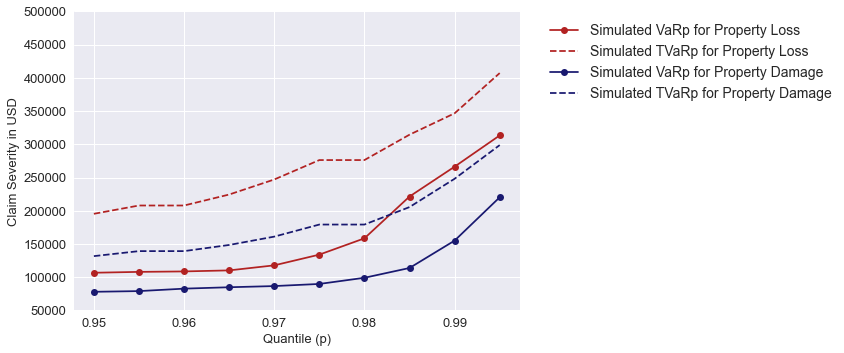

In [23]:
#comparative graph for VaR of property loss and property damage:
#VaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, vpl4, 'y-o', color="firebrick", label="Simulated VaRp for Property Loss")
plt.plot(pi, tvpl4, '--', color="firebrick", label="Simulated TVaRp for Property Loss")
plt.plot(pi, vpd4, 'y-o', color="midnightblue", label="Simulated VaRp for Property Damage")
plt.plot(pi, tvpd4, '--', color="midnightblue", label="Simulated TVaRp for Property Damage")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Claim Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('basic_comparison.png', dpi=300, bbox_inches='tight')

**Making the graphs for the Property Loss Severity:**

In [24]:
#HISTORICAL VAR AND TVAR for PLS:
hvar = []
for c in pi:
    hvar.append(VAR(df.iloc[:,[4]],c))
    
htvar = []
for c in pi:
    htvar.append(TVAR(df.iloc[:,[4]],c))

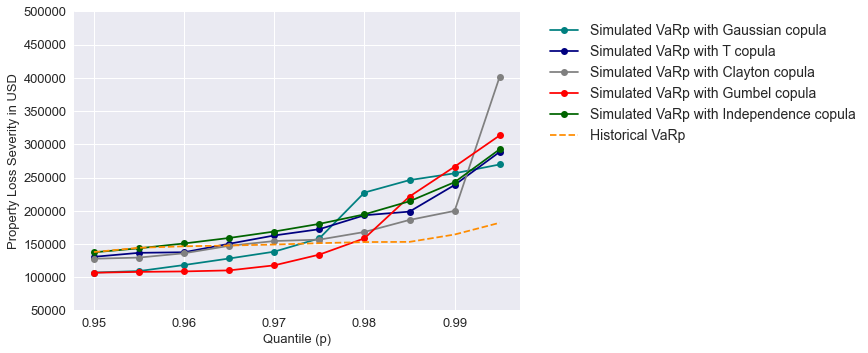

In [25]:
#VaR plot for different copulas:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, vpl1, 'y-o', color="teal", label="Simulated VaRp with Gaussian copula")
plt.plot(pi, vpl2, 'y-o', color="navy", label="Simulated VaRp with T copula")
plt.plot(pi, vpl3, 'y-o', color="gray", label="Simulated VaRp with Clayton copula")
plt.plot(pi, vpl4, 'y-o', color="red", label="Simulated VaRp with Gumbel copula")
plt.plot(pi, vpl5, 'y-o', color="darkgreen", label="Simulated VaRp with Independence copula")
plt.plot(pi, hvar, '--', color="darkorange", label="Historical VaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Property Loss Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('pls_var.png', dpi=300, bbox_inches='tight')

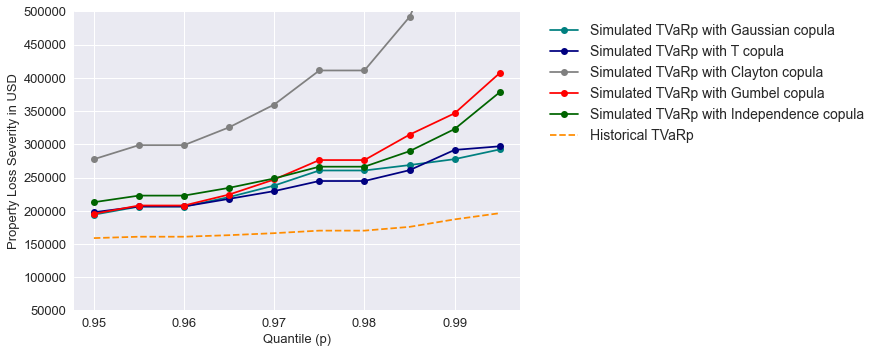

In [34]:
#TVaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, tvpl1, 'y-o', color="teal", label="Simulated TVaRp with Gaussian copula")
plt.plot(pi, tvpl2, 'y-o', color="navy", label="Simulated TVaRp with T copula")
plt.plot(pi, tvpl3, 'y-o', color="gray", label="Simulated TVaRp with Clayton copula")
plt.plot(pi, tvpl4, 'y-o', color="red", label="Simulated TVaRp with Gumbel copula")
plt.plot(pi, tvpl5, 'y-o', color="darkgreen", label="Simulated TVaRp with Independence copula")
plt.plot(pi, htvar, '--', color="darkorange", label="Historical TVaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Property Loss Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('pls_tvar.png', dpi=300, bbox_inches='tight')

**Making the graphs for the Property Damage Severity:**

In [35]:
#HISTORICAL VAR AND TVAR for PDS:
hvar2 = []
for c in pi:
    hvar2.append(VAR(df.iloc[:,[2]],c))
    
htvar2 = []
for c in pi:
    htvar2.append(TVAR(df.iloc[:,[2]],c))
    

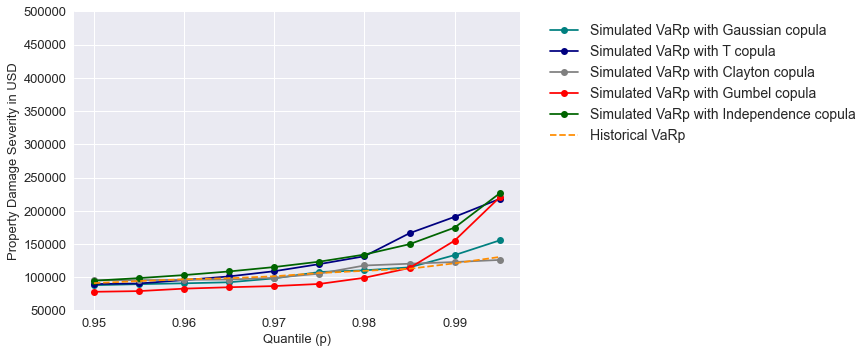

In [36]:
#VaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi,vpd1, 'y-o', color="teal", label="Simulated VaRp with Gaussian copula")
plt.plot(pi, vpd2, 'y-o', color="navy", label="Simulated VaRp with T copula")
plt.plot(pi, vpd3, 'y-o', color="gray", label="Simulated VaRp with Clayton copula")
plt.plot(pi, vpd4, 'y-o', color="red", label="Simulated VaRp with Gumbel copula")
plt.plot(pi, vpd5, 'y-o', color="darkgreen", label="Simulated VaRp with Independence copula")
plt.plot(pi, hvar2, '--', color="darkorange", label="Historical VaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Property Damage Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('pds_var.png', dpi=300, bbox_inches='tight')

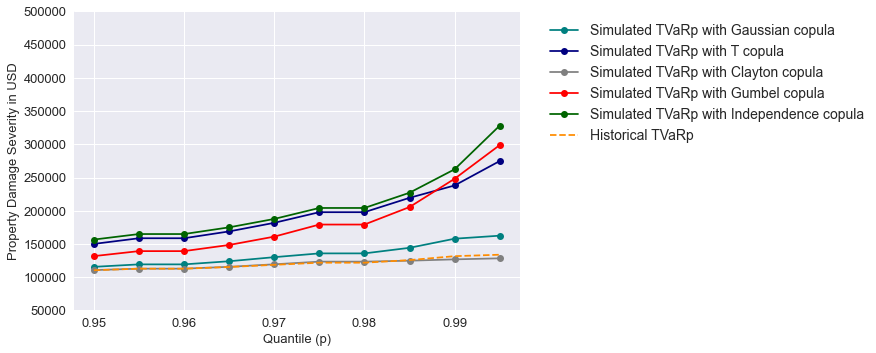

In [37]:
#TVaR plot:
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('seaborn') 
plt.plot(pi, tvpd1, 'y-o', color="teal", label="Simulated TVaRp with Gaussian copula")
plt.plot(pi, tvpd2, 'y-o', color="navy", label="Simulated TVaRp with T copula")
plt.plot(pi, tvpd3, 'y-o', color="gray", label="Simulated TVaRp with Clayton copula")
plt.plot(pi, tvpd4, 'y-o', color="red", label="Simulated TVaRp with Gumbel copula")
plt.plot(pi, tvpd5, 'y-o', color="darkgreen", label="Simulated TVaRp with Independence copula")
plt.plot(pi, htvar2, '--', color="darkorange", label="Historical TVaRp")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Property Damage Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('pds_tvar.png', dpi=300, bbox_inches='tight')

In [45]:
#summary:
ftable = pd.DataFrame({'Risk Measure': ['VaR Property Loss', 'VaR Property Damage', 'TVaR Property Loss', 'TVaR Property Damage'],
                       'Historical' : [181897.39475, 130443.5615, 196328.29, 133835.07],
                      'Gaussian' : [vpl1[-1], vpd1[-1], tvpl1[-1], tvpd1[-1]],
                      'Student t' : [vpl2[-1], vpd2[-1], tvpl2[-1], tvpd2[-1]],
                      'Clayton' : [vpl3[-1], vpd3[-1], tvpl3[-1], tvpd3[-1]],
                     'Gumbel' : [vpl4[-1], vpd4[-1], tvpl4[-1], tvpd4[-1]],
                      'Independence' : [vpl5[-1], vpd5[-1], tvpl5[-1], tvpd5[-1]]})
ftable.head()

,Risk Measure,Historical,Gaussian,Student t,Clayton,Gumbel,Independence
0,VaR Property Loss,181897.39475,269656.821436,288564.978478,4.018263e+05,313373.994473,292540.701710
1,VaR Property Damage,130443.56150,155413.861648,217871.753993,1.259641e+05,220262.346644,226264.984443
2,TVaR Property Loss,196328.29000,292260.456043,296987.349235,1.074281e+06,407208.383066,378359.627156
3,TVaR Property Damage,133835.07000,162481.016316,274806.537097,1.283962e+05,298815.097212,328110.801327


### 3. Comparison between Empirical marginals vs. Marginals

In [41]:
#making the empirical distributions:
from statsmodels.distributions.empirical_distribution import ECDF

E1 = ECDF(df['pds'])
epds = list(E1(df['pds']))

E2 = ECDF(df['pls'])
epls = list(E2(df['pls']))

E3 = ECDF(df['pdx'])
epdx = list(E3(df['pdx']))

E4 = ECDF(df['plx'])
eplx = list(E4(df['plx']))

dfemp = pd.DataFrame({'EPDX': epdx, 'EPLX' : eplx, 'EPDS': epds, 'EPLS': epls})

dfemp.head()

,EPDX,EPLX,EPDS,EPLS
0,0.750000,0.557692,0.692308,0.685897
1,0.807692,0.634615,0.769231,0.679487
2,0.826923,0.717949,0.839744,0.833333
3,0.852564,0.788462,0.903846,0.852564
4,0.820513,0.698718,0.833333,0.794872


In [46]:
#fiting a Gumbel copula for the empirical marginals:
from copulae import GumbelCopula
#setting the dimensions:
_, ndim = dfemp.shape
#setting the dimensions:
gucop2 = GumbelCopula(dim=ndim)

#initializing the copula:
gucop2.fit(dfemp)

#printing the log-likelihood and the parameter:
print(gucop2.log_lik(dfemp, to_pobs=False), gucop2.params)

-inf 3.126137422221151


In [44]:
####################################### EMPIRICAL MARGINALS WITH GUMBEL COPULA SIMULATION#########
pi = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]

#generating 10000 simulations:
sims = {}
for it in range(0,10000):
    sims[it] = gucop2.random(len(dfemp))

PLS = {}
for key in tqdm(sims):
    PLS[key] = np.quantile(df['pls'], sims[key].iloc[:,3])

#creating VaR and TVaR dictionaries for the simulations for PLS:
vpl = []
tvpl = []
for p in tqdm(pi):
    var_pls = {}
    tvar_pls = {}
    for key in PLS:
        var_pls[key] = np.quantile(PLS[key], p, axis = 0)
        tvar_pls[key] = PLS[key][PLS[key] >= var_pls[key]].mean()
    vpl.append(mean(list(var_pls.values())))
    tvpl.append(mean(list(tvar_pls.values())))
    
PDS = {}
for key in tqdm(sims):
    PDS[key] = np.quantile(df['pds'], sims[key].iloc[:,2])

#creating VaR and TVaR dictionaries for the simulations for PDS:
vpd = []
tvpd = []
for p in tqdm(pi):
    var_pds = {}
    tvar_pds = {}
    for key in PDS:
        var_pds[key] = np.quantile(PDS[key], p, axis = 0)
        tvar_pds[key] = PDS[key][PDS[key] >= var_pds[key]].mean()
    vpd.append(mean(list(var_pds.values())))
    tvpd.append(mean(list(tvar_pds.values())))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


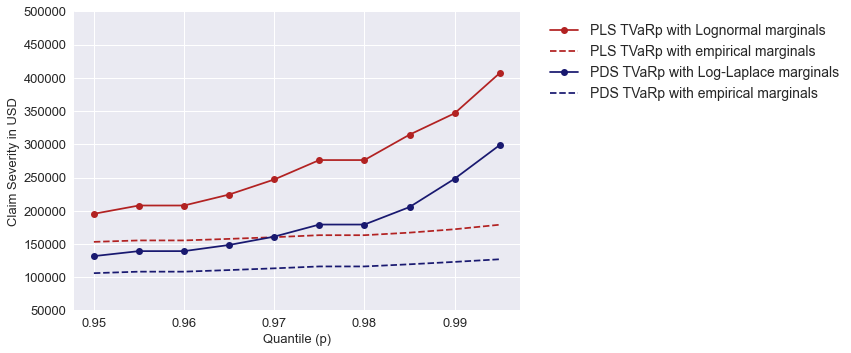

In [47]:
plt.plot(pi, tvpl4, 'y-o', color="firebrick", label="PLS TVaRp with Lognormal marginals")
plt.plot(pi, tvpl, '--', color="firebrick", label="PLS TVaRp with empirical marginals")
plt.plot(pi, tvpd4, 'y-o', color="midnightblue", label="PDS TVaRp with Log-Laplace marginals")
plt.plot(pi, tvpd, '--', color="midnightblue", label="PDS TVaRp with empirical marginals")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
plt.xlabel("Quantile (p)", fontsize=13) 
plt.ylabel("Claim Severity in USD", fontsize=13)
plt.ylim(50000, 500000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('empirical_comparison.png', dpi=300, bbox_inches='tight')